In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [606]:
# choose a list of 5 countries to start with abundant data
countries = ['Australia', 'Canada', 'Spain', 'Norway', 'Brazil', 'Germany', 'Chile', 'Argentina', 'India', 'Finland', 'France', 'Sweden', 'Japan', 'Netherlands']

In [500]:
def compute_percent_change_features(country_list, start_date, train_date, test_date):
    def percent_change(new, original):
        return (new - original) / original
    
    # store dataframes in lists
    df_list = []

    for country in countries:
        country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
        
        # check if there's no organizations, if so use number of occurences of country as backup
        for index, orgs in enumerate(country_df['Country Specific Orgs']):
            if orgs == 0:
                country_df.at[index, 'Country Specific Orgs'] = str(country_df.at[index, 'Addresses']).count(country)
        
        country_df = country_df.drop(columns=['Country Specific Authors'])
        country_df = country_df[country_df['Country Specific Orgs'] > 0]
        country_df = country_df.reset_index(drop=True)

        # get papers from 1998 and onwards
        country_df = country_df[country_df['Publication Year'] >= 1998]
        country_df = country_df.reset_index(drop=True)
        df_list.append(country_df)

    country_train = []
    country_test = []

    for country_data in df_list:
        train_data = pd.DataFrame(dict({'Year': np.zeros(train_date - 1998 + 1), 'Paper Volume': np.zeros(train_date - 1998 + 1), 'Mean Adj. Citations': np.zeros(train_date - 1998 + 1), 'Mean Orgs': np.zeros(train_date - 1998 + 1)}))
        test_data = pd.DataFrame(dict({'Year': np.zeros(test_date - train_date + 1), 'Paper Volume': np.zeros(test_date - train_date + 1), 'Mean Adj. Citations': np.zeros(test_date - train_date + 1), 'Mean Orgs': np.zeros(test_date - train_date + 1)}))
        for date in range(1998, test_date + 1):
            year_data = country_data[country_data['Publication Year'] == date]
            year_data = year_data.reset_index(drop=True)

            if date < train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            elif date == train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            else:
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]

        country_train.append(train_data)
        country_test.append(test_data)
    
    protected_df = pd.read_csv('protected_land_cleaned.csv')
    
    # now compute the percent changes starting from start_date (i.e. can start analysis in start_date + 1)
    
    percent_change_train = []
    percent_change_test = []
    percent_change_protected_test = []
    percent_change_protected_train = []

    for train_df in country_train:
        percent_train = pd.DataFrame(dict({'Change_Volume': np.zeros(train_date - start_date), 'Change_Citations': np.zeros(train_date - start_date), 'Change_Orgs': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            percent_train.iloc[i] = [percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Paper Volume'], train_df.iloc[start_date - 1998 + i]['Paper Volume']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Adj. Citations'], train_df.iloc[start_date - 1998 + i]['Mean Adj. Citations']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Orgs'], train_df.iloc[start_date - 1998 + i]['Mean Orgs'])]
        percent_change_train.append(percent_train)

    for test_df in country_test:    
        percent_test = pd.DataFrame(dict({'Change_Volume': np.zeros(test_date - train_date), 'Change_Citations': np.zeros(test_date - train_date), 'Change_Orgs': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            percent_test.iloc[i] = [percent_change(test_df.iloc[1 + i]['Paper Volume'], test_df.iloc[i]['Paper Volume']), percent_change(test_df.iloc[1 + i]['Mean Adj. Citations'], test_df.iloc[i]['Mean Adj. Citations']), percent_change(test_df.iloc[1 + i]['Mean Orgs'], test_df.iloc[i]['Mean Orgs'])]
        percent_change_test.append(percent_test)

    for country in countries:
        country_protected = protected_df[protected_df['Country'] == country]
        country_protected = country_protected[country_protected['Year'] >= start_date]
        country_protected = country_protected[country_protected['Year'] <= test_date]
        country_protected = country_protected.reset_index(drop=True)

        protect_change_train = pd.DataFrame(dict({'Change_Protected_Percent': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            protect_change_train.iloc[i] = [percent_change(country_protected.iloc[1 + i]['Value'], country_protected.iloc[0 + i]['Value'])]
        percent_change_protected_train.append(protect_change_train)

        protect_change_test = pd.DataFrame(dict({'Change_Protected_Percent': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            protect_change_test.iloc[i] = [percent_change(country_protected.iloc[train_date - start_date + 1 + i]['Value'], country_protected.iloc[train_date - start_date + i]['Value'])]
        percent_change_protected_test.append(protect_change_test)
        
    return percent_change_train, percent_change_test, percent_change_protected_train, percent_change_protected_test

In [501]:
X_train_list, X_test_list, y_train_list, y_test_list = compute_percent_change_features(countries, 2000, 2016, 2021)

C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/3558127889.py:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/3558127889.py:9: DtypeWarning: Columns (11,15,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/3558127889.py:9: DtypeWarning: Columns (15,50) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/3558127889.py:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/355

In [502]:
X_train_list[0]

,Change_Volume,Change_Citations,Change_Orgs
0,0.377358,-0.697482,-0.149511
1,0.273973,0.400608,0.097648
2,0.258065,-0.074747,0.072153
3,0.102564,0.930533,-0.069567
4,0.069767,-0.476985,0.017263
5,0.166667,1.355956,0.059018
6,0.590062,-0.362556,0.110413
7,-0.078125,0.074822,-0.368352
8,0.627119,-0.243324,-0.011810
9,0.177083,0.272235,0.032638


In [80]:
def calc_MSE(y_pred, y_true):
    return (1/len(y_pred))*sum(((np.array(y_pred)-np.array(y_true))**2))[0]

In [188]:
# build a simple Linear Regression Model for Country 0 (Australia)

regr = LinearRegression()
regr = regr.fit(X_train_list[0], y_train_list[0])

# get MSE on the test set
calc_MSE(regr.predict(X_test_list[0]), y_test_list[0])

0.004680588803185362

In [165]:
regr.predict(X_test_list[3])

array([[-0.00888445],
       [ 0.01731364],
       [ 0.1218486 ],
       [ 0.02697975]])

In [166]:
y_test_list[3]

,Change Protected Percent
0,0.048655
1,0.007482
2,0.000000
3,0.000000


In [167]:
regr.coef_[0]

array([ 0.14693616, -0.0579826 ,  0.14041282, -0.31600658])

In [158]:
from sklearn.preprocessing import PolynomialFeatures

# choose polynomial order than minimizes MSE on test set
degrees = list(range(1, 11))

for degree in degrees:
    # polynomial feature transform
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train_list[1])
    X_poly_test = poly.transform(X_test_list[1])

    # fit a model with the new polynomial features
    poly_regr = LinearRegression()
    poly_regr = poly_regr.fit(X_poly_train, y_train_list[1])

    # get MSE on test set
    print(f'MSE of Degree {degree} polynomial: {calc_MSE(poly_regr.predict(X_poly_test), y_test_list[1])}')

MSE of Degree 1 polynomial: 0.00031597996855801453
MSE of Degree 2 polynomial: 0.0016687974607936063
MSE of Degree 3 polynomial: 0.0012711090702247302
MSE of Degree 4 polynomial: 0.001318833790740374
MSE of Degree 5 polynomial: 0.001281865801931545
MSE of Degree 6 polynomial: 0.0012919365007712747
MSE of Degree 7 polynomial: 0.0012877362771523152
MSE of Degree 8 polynomial: 0.0012888275798317785
MSE of Degree 9 polynomial: 0.0012884853731590686
MSE of Degree 10 polynomial: 0.0012885834350130142


In [503]:
def shift_data(shift, X_train_list, X_test_list, y_train_list, y_test_list):
    X_shifted_train_list = []
    X_shifted_test_list = []
    y_shifted_train_list = []
    y_shifted_test_list = []
    
    for index, df in enumerate(X_train_list):
        X_shifted = X_train_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_train_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change_Volume_Prev_{shift_i + 1}', f'Change_Citations_Prev_{shift_i + 1}', f'Change_Orgs_Prev_{shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_train_list.append(X_shifted)
        y_shifted_train_list.append(y_train_list[index][shift:])
    
    for index, df in enumerate(X_test_list):
        X_shifted = X_test_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_test_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change_Volume_Prev_{shift_i + 1}', f'Change_Citations_Prev_{shift_i + 1}', f'Change_Orgs_Prev_{shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_test_list.append(X_shifted)
        y_shifted_test_list.append(y_test_list[index][shift:])
    
    return X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list

In [504]:
X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list = shift_data(3, X_train_list, X_test_list, y_train_list, y_test_list)

In [438]:
# Ridge and Lasso Regression on shifted data
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

ridge_regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_shifted_train_list[0], y_shifted_train_list[0])
lasso_regr = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_shifted_train_list[0], y_shifted_train_list[0])

# get MSE on the test set
print(f'Ridge MSE: {calc_MSE(ridge_regr.predict(X_shifted_test_list[0]), y_shifted_test_list[0])}')
print(f'Lasso MSE: {calc_MSE(lasso_regr.predict(X_shifted_test_list[0]), y_shifted_test_list[0])}')


Ridge MSE: 0.0015614176111169733
Lasso MSE: 0.0015244600355036491


C:\Users\btiv\anaconda3\envs\sklearn-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [483]:
degrees = list(range(1, 5))

for degree in degrees:
    # polynomial feature transform
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_shifted_train_list[0])
    X_poly_test = poly.transform(X_shifted_test_list[0])

    # fit a model with the new polynomial features
    poly_regr = LassoCV(alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], max_iter=100000)
    poly_regr = poly_regr.fit(X_poly_train, np.ravel(y_shifted_train_list[0]))

    # get MSE on test set
    print(f'MSE of Degree {degree} polynomial: {calc_MSE(poly_regr.predict(X_poly_test), y_shifted_test_list[0])}')

MSE of Degree 1 polynomial: 0.0019458954790942586
MSE of Degree 2 polynomial: 0.0019458954790942586
MSE of Degree 3 polynomial: 0.0019893683997272054
MSE of Degree 4 polynomial: 0.0021012281580696296


In [433]:
poly_regr.coef_

array([[ 0.00000000e+00,  1.95864104e-04, -5.86294864e-04,
         1.38173831e-04, -4.45994403e-04,  1.81375045e-04,
         4.36962795e-06, -1.22271686e-04, -3.97552671e-04,
         1.87057320e-04,  9.71925838e-05, -1.34222894e-04,
         1.63125302e-06, -1.68720920e-05,  1.75006967e-04,
         1.13740620e-06,  2.68138156e-06,  8.42608830e-06,
         5.10423605e-05, -8.14101072e-04,  1.45688592e-05,
        -1.75704148e-04,  2.53381211e-04, -3.98268485e-05,
        -7.04036035e-05, -4.16754828e-04,  2.34662527e-05,
        -3.73633883e-05,  6.48627972e-05, -1.99920030e-05,
         1.48832896e-05,  2.73251881e-05,  1.76084726e-04,
         1.63139552e-05, -2.70539251e-04,  1.12546786e-04,
        -2.62491759e-05, -7.44135091e-05, -2.41231401e-04,
         7.61753353e-05, -3.20926170e-05,  4.60160775e-05,
        -9.77194389e-05,  2.30613424e-04, -1.43123066e-05,
         3.24547554e-06, -1.85520061e-05, -2.03494914e-05,
         3.74076549e-06, -5.13906214e-05,  4.05024855e-0

In [440]:
ridge_regr.coef_[0]

array([ 3.13821194e-04, -7.13338459e-04,  1.77776607e-04, -3.44847242e-04,
        4.88995077e-04, -8.37930725e-06, -9.49436201e-05, -5.83699258e-04,
        1.45546802e-04])

In [341]:
lasso_regr.predict(X_shifted_test_list[3])

array([0.0238768, 0.0238768])

In [455]:
X_shifted_train_list[0]

,Change Volume,Change Citations,Change Orgs,Change Volume Prev 1,Change Citations Prev 1,Change Orgs Prev 1,Change Volume Prev 2,Change Citations Prev 2,Change Orgs Prev 2,Change Volume Prev 3,Change Citations Prev 3,Change Orgs Prev 3
3,0.102564,0.930533,-0.069567,0.258065,-0.074747,0.072153,0.273973,0.400608,0.097648,0.377358,-0.697482,-0.149511
4,0.069767,-0.476985,0.017263,0.102564,0.930533,-0.069567,0.258065,-0.074747,0.072153,0.273973,0.400608,0.097648
5,0.166667,1.355956,0.059018,0.069767,-0.476985,0.017263,0.102564,0.930533,-0.069567,0.258065,-0.074747,0.072153
6,0.590062,-0.362556,0.110413,0.166667,1.355956,0.059018,0.069767,-0.476985,0.017263,0.102564,0.930533,-0.069567
7,-0.078125,0.074822,-0.368352,0.590062,-0.362556,0.110413,0.166667,1.355956,0.059018,0.069767,-0.476985,0.017263
8,0.627119,-0.243324,-0.011810,-0.078125,0.074822,-0.368352,0.590062,-0.362556,0.110413,0.166667,1.355956,0.059018
9,0.177083,0.272235,0.032638,0.627119,-0.243324,-0.011810,-0.078125,0.074822,-0.368352,0.590062,-0.362556,0.110413
10,0.044248,-0.038446,0.087197,0.177083,0.272235,0.032638,0.627119,-0.243324,-0.011810,-0.078125,0.074822,-0.368352
11,0.129237,0.133113,0.045681,0.044248,-0.038446,0.087197,0.177083,0.272235,0.032638,0.627119,-0.243324,-0.011810
12,0.157598,0.000193,-0.079020,0.129237,0.133113,0.045681,0.044248,-0.038446,0.087197,0.177083,0.272235,0.032638


In [505]:
# run lasso regression over each country, compute the mean model and then measure performance

coef_df = pd.DataFrame(dict({'Coef_1': np.zeros(len(X_shifted_train_list)), 'Coef_2': np.zeros(len(X_shifted_train_list)),
                            'Coef_3': np.zeros(len(X_shifted_train_list)), 'Coef_4': np.zeros(len(X_shifted_train_list)),
                            'Coef_5': np.zeros(len(X_shifted_train_list)), 'Coef_6': np.zeros(len(X_shifted_train_list)),
                            'Coef_7': np.zeros(len(X_shifted_train_list)), 'Coef_8': np.zeros(len(X_shifted_train_list)),
                            'Coef_9': np.zeros(len(X_shifted_train_list)), 'Coef_10': np.zeros(len(X_shifted_train_list)),
                            'Coef_11': np.zeros(len(X_shifted_train_list)), 'Coef_12': np.zeros(len(X_shifted_train_list)),
                            'intercept': np.zeros(len(X_shifted_train_list))}))

for i in range(len(X_shifted_train_list)):
    lasso_regr = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], max_iter=100000).fit(X_shifted_train_list[i], np.ravel(y_shifted_train_list[i]))
    coef_df.iloc[i] = [lasso_regr.coef_[0], lasso_regr.coef_[1], lasso_regr.coef_[2], lasso_regr.coef_[3],
                      lasso_regr.coef_[4], lasso_regr.coef_[5], lasso_regr.coef_[6], lasso_regr.coef_[7],
                      lasso_regr.coef_[8], lasso_regr.coef_[9], lasso_regr.coef_[10], lasso_regr.coef_[11],
                      lasso_regr.intercept_]

coef_df.mean()

Coef_1       0.000000
Coef_2       0.003332
Coef_3       0.000000
Coef_4       0.000123
Coef_5       0.005639
Coef_6       0.000000
Coef_7       0.000313
Coef_8       0.000976
Coef_9       0.000000
Coef_10      0.000294
Coef_11      0.003275
Coef_12      0.000000
intercept    0.028143
dtype: float64

In [488]:
coef_df

,Coef_1,Coef_2,Coef_3,Coef_4,Coef_5,Coef_6,Coef_7,Coef_8,Coef_9,Coef_10,Coef_11,Coef_12,intercept
0,0.0,-0.000000,0.0,-0.000000,0.000000,0.0,-0.000000,-0.000000,0.0,0.000000,0.000000,-0.0,0.061251
1,0.0,-0.012190,-0.0,-0.000000,0.000000,-0.0,0.004386,0.011327,-0.0,0.000000,0.005816,-0.0,0.020187
2,0.0,0.058831,-0.0,0.000000,0.040121,0.0,0.000000,0.002342,0.0,0.000591,0.040033,0.0,0.008023
3,-0.0,-0.000000,-0.0,0.000000,0.035292,-0.0,-0.000000,-0.000000,-0.0,-0.000000,0.000000,0.0,0.040660
4,-0.0,0.000000,-0.0,0.000000,-0.000000,-0.0,0.000000,0.000000,0.0,-0.000000,0.000000,0.0,0.036422
5,-0.0,0.000000,-0.0,0.000000,0.000000,0.0,-0.000000,-0.000000,-0.0,0.000000,-0.000000,-0.0,0.032356
6,-0.0,-0.000000,-0.0,0.001724,0.000000,-0.0,-0.000000,-0.000000,0.0,0.000000,-0.000000,0.0,0.006053
7,0.0,-0.000000,-0.0,0.000000,-0.000000,0.0,-0.000000,0.000000,-0.0,0.000000,0.000000,-0.0,0.013740
8,0.0,0.000000,-0.0,-0.000000,-0.000000,-0.0,0.000000,0.000000,0.0,0.000000,-0.000000,-0.0,0.041047
9,-0.0,0.000000,0.0,0.000000,-0.000000,0.0,-0.000000,-0.000000,-0.0,0.000000,0.000000,0.0,0.020833


In [424]:
def linear_pred(mean_coefs, X_shifted_test):
    pred = 0
    for index, coef in enumerate(mean_coefs):
        if index < len(mean_coefs) - 1:
            pred += coef * X_shifted_test[index]
        else:
            # intercept
            pred += coef
    return pred

In [487]:
# test performance of mean model, calculating MSE for each country
for i in range(len(X_shifted_test_list)):
    preds = [linear_pred(np.array(coef_df.mean()), X_shifted_test_list[i].iloc[index]) for index in range(len(X_shifted_test_list[i]))]
    print(f'MSE for {countries[i]} is {calc_MSE(preds, y_shifted_test_list[i])}')

MSE for Australia is 0.0006105865325438684
MSE for Canada is 0.000333431911693465
MSE for Spain is 0.0006453063602849491
MSE for Norway is 0.0006444921193092028
MSE for Brazil is 0.0006517038858403292
MSE for Germany is 0.0006459340260071218
MSE for Chile is 0.0007247159090547346
MSE for Argentina is 0.0006469505407784167
MSE for India is 0.0007514550551949649
MSE for Finland is 0.0006644785653261251
MSE for France is 0.0006351448270646833
MSE for Sweden is 0.0006363568087099209
MSE for Japan is 0.0007003150208264954
MSE for Netherlands is 0.0006213368397329894


In [ ]:
# test the model on countries not used for training


In [479]:
protected_df = pd.read_csv('protected_land_cleaned.csv')
for country in protected_df['Country'].unique():
    country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
    print(f'{country}: {len(country_df)}')

C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/2842962683.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


Australia: 11732
Austria: 2655
Belgium: 3571


C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/2842962683.py:3: DtypeWarning: Columns (11,15,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


Canada: 8948
Czech Republic: 2950
Denmark: 2929
Finland: 3219


C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/2842962683.py:3: DtypeWarning: Columns (6,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


France: 12297


C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/2842962683.py:3: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


Germany: 15375
Greece: 1289
Hungary: 1259
Iceland: 133
Ireland: 1235


C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/2842962683.py:3: DtypeWarning: Columns (11,15,50,53) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


Italy: 8982
Japan: 3851
Korea: 1482
Luxembourg: 173
Mexico: 4279
Netherlands: 5985
New Zealand: 2684
Norway: 2321
Poland: 3265
Portugal: 3255
Slovak Republic: 0


C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/2842962683.py:3: DtypeWarning: Columns (15,50) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


Spain: 8957
Sweden: 4920
Switzerland: 5764
United Kingdom: 19
United States: 10
G7: 211
NAFTA: 1
American Samoa: 0
Anguilla: 13
Argentina: 2558
Armenia: 87
Aruba: 6
Azerbaijan: 39
Belarus: 86
Bermuda: 14


C:\Users\btiv\AppData\Local\Temp/ipykernel_37148/2842962683.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


Brazil: 11101
British Virgin Islands: 0
Bulgaria: 578
Cayman Islands: 5
Chile: 1821
China (People's Republic of): 0
Colombia: 1556
Cook Islands: 1
Costa Rica: 662
Croatia: 580
Cyprus: 167
Estonia: 842
Faeroe Islands: 0
Falkland Islands (Malvinas): 0
French Guiana: 132
French Polynesia: 10
Georgia: 1132
Gibraltar: 2
Greenland: 46
Guadeloupe: 75
Guam: 57
India: 5494
Indonesia: 2181
Israel: 1030
Kazakhstan: 106
Kyrgyzstan: 46
Latvia: 175
Lithuania: 344
Malta: 89
Martinique: 36
Mayotte: 4
Moldova: 47
Montserrat: 114
New Caledonia: 143
Niue: 2
Norfolk Island: 0
Northern Mariana Islands: 1
Peru: 998
Pitcairn: 0
Puerto Rico: 213
Réunion: 0
Romania: 1129
Russia: 3347
Saint Helena: 0
Saint Pierre and Miquelon: 0
Saudi Arabia: 581
Slovenia: 643
South Africa: 4784
Svalbard and Jan Mayen: 0
Tajikistan: 14
Tokelau: 0
Turkmenistan: 1
Turks and Caicos Islands: 0
Ukraine: 457
Uzbekistan: 67
United States Virgin Islands: 0
Wallis and Futuna: 0
World: 1645
Bouvet Island: 0
Heard Island and McDonald Isla

FileNotFoundError: [Errno 2] No such file or directory: 'European Union – 27 countries (from 01/02/2020)_biodiversity_research.csv'

In [528]:
# lets try a GAM
import patsy as pat

# for every country
for i in range(len(X_shifted_train_list)):
    # determine optimal degree of freedom
    degs_of_freedom = list(range( 1, 11))
    optimal_deg_freedom = 0
    optimal_MSE = np.inf
    for deg_of_freedom in degs_of_freedom:
        formula = ''
        for col_str in X_shifted_train_list[i]:
            formula = formula + 'cr(' + col_str + ', df='+ str(int(3 + deg_of_freedom)) + ') +'
        formula = formula[:-1]

        X_spline_train = pat.dmatrix(formula, X_shifted_train_list[i])
        X_spline_test = pat.dmatrix(formula, X_shifted_test_list[i])

        # build linear regression model
        spline_model = LinearRegression().fit(X_spline_train, y_shifted_train_list[i])
        mse = calc_MSE(spline_model.predict(X_spline_test), y_shifted_test_list[i])

        if mse < optimal_MSE:
            optimal_MSE = mse
            optimal_deg_freedom = deg_of_freedom

    print(optimal_deg_freedom)
    print(optimal_MSE)

3
0.0012561452300151785
6
0.0004650149295408091
4
0.0005436813165126356
9
0.003522852052188722
2
0.0018139719146199505
2
0.0009285224827544464
4
3.608448304157973e-05
10
0.0004104678635698337
1
0.0023966451217740173
3
7.071243694741908e-05
4
0.0016706061907014388
9
0.0005191906386833858
4
3.670257195644281e-05
2
0.003475429781472554


GAM models are all over the place, likely won't have good aggregated results. Can talk about increased performance on specific countries but high variability on test set performance and model creation

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-29.190, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-30.521, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-29.309, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-28.952, Time=0.00 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-34.034, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-32.331, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-32.291, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-30.362, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.193 seconds


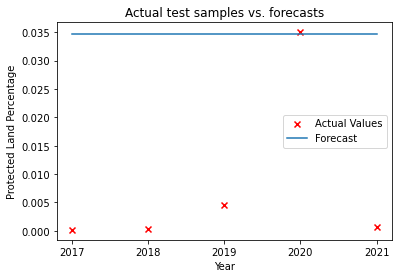

In [609]:
# train the ARIMA model

import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

# run ARIMA on Australia data from 2000 onwards
# protected_df = pd.read_csv('protected_land_cleaned.csv')
# canada_percentages = protected_df[protected_df['Country'] == 'Canada']
# canada_percentages = np.array(canada_percentages['Value'])

train, test = model_selection.train_test_split(y_train_list[2], train_size=0.7)


arima = pm.auto_arima(train, start_p=1, start_q=1,
                             max_p=10, max_q=10,
                             start_P=0,
                             trace=True, seasonal=False,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise


x = np.arange(test.shape[0])
plt.scatter(2022 - len(x) + x, test, color='r', marker='x', label='Actual Values')
plt.plot(2022 - len(x) + x, arima.predict(n_periods=test.shape[0]), label='Forecast')
plt.title('Actual test samples vs. forecasts')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Protected Land Percentage')
plt.xticks(np.arange(min(2022 - len(x) + x), max(2022 - len(x) + x) + 1, 1.0))
plt.show()

Text(0, 0.5, 'Protected Land Percentage')

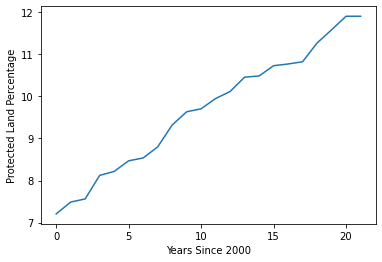

In [598]:
plt.plot(canada_percentages[7:])
plt.xlabel('Years Since 2000')
plt.ylabel('Protected Land Percentage')